# Section 2 – Supervised learning – classification


The second task consists on classifying the flows according to the attack – supervised classification. You are provided by a ground truth containing the label of the attacks. In the 
provided GT you can find different names of the attacks. 
1. Perform a split to segment the dataset into training and test dataset, in a stratified 
way with respect to the labels.
2. Choose at least **3** ML methods, and perform the model training, with default 
parameter configuration, evaluating the performance on both training and test set. 
Output the confusion matrix and classification report. Do you observe overfitting or 
under-fitting? 
3. Tune the hyper-parameters of the models through cross-validation. How do 
performance vary? Which model generates the best performance?
4. Investigate the False Positive and False Negative. Can you draw considerations about 
the misclassification in terms of features? Report your analysis and findings for the 
ones you consider the most notable samples.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer, f1_score
from sklearn.model_selection import validation_curve, StratifiedKFold, GridSearchCV, cross_val_score, RandomizedSearchCV
from scipy.stats import uniform, randint

# Import models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv("ddos_dataset.csv",index_col=[0])
df

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (85) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,label
0,172.16.0.5-192.168.50.1-634-60495-17,172.16.0.5,634,192.168.50.1,60495,17,2018-12-01 10:51:39.813448,28415,97,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
1,172.16.0.5-192.168.50.1-60495-634-17,192.168.50.1,634,172.16.0.5,60495,17,2018-12-01 10:51:39.820842,2,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,ddos_dns
2,172.16.0.5-192.168.50.1-634-46391-17,172.16.0.5,634,192.168.50.1,46391,17,2018-12-01 10:51:39.852499,48549,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
3,172.16.0.5-192.168.50.1-634-11894-17,172.16.0.5,634,192.168.50.1,11894,17,2018-12-01 10:51:39.890213,48337,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
4,172.16.0.5-192.168.50.1-634-27878-17,172.16.0.5,634,192.168.50.1,27878,17,2018-12-01 10:51:39.941151,32026,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65995,172.16.0.5-192.168.50.1-38625-63051-17,172.16.0.5,38625,192.168.50.1,63051,17,2018-12-01 13:04:46.628249,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
65996,172.16.0.5-192.168.50.1-58632-18963-17,172.16.0.5,58632,192.168.50.1,18963,17,2018-12-01 13:04:46.628963,212238,6,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
65997,172.16.0.5-192.168.50.1-46104-64704-17,172.16.0.5,46104,192.168.50.1,64704,17,2018-12-01 13:04:46.629014,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
65998,172.16.0.5-192.168.50.1-60686-10440-17,172.16.0.5,60686,192.168.50.1,10440,17,2018-12-01 13:04:46.629016,108952,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag


In [3]:
df["Flow ID"] = df[" Source IP"].astype(str)+"-"+df[" Destination IP"].astype(str)+"-"+df[" Source Port"].astype(str)+"-"+df[" Destination Port"].astype(str)+"-"+df[" Protocol"].astype(str)

df_processing = df.copy()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to the 'Category' column
df_processing['label'] = label_encoder.fit_transform(df_processing['label'])


columns=["Protocol_0","Protocol_6","Protocol_17"]
encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(df_processing[[' Protocol']])
one_hot_encoded_array = one_hot_encoded.toarray()
one_hot_encoded_df = pd.DataFrame(one_hot_encoded_array, columns=columns,index=df.index)
df_processing = pd.concat([df_processing, one_hot_encoded_df], axis=1)

def isMostFrequent(port,par):
    if par==1:
         return not(port in most_frequent_source_ports)
    else:
         return not(port in most_frequent_destination_ports)

most_frequent_source_ports = df_processing[" Source Port"].value_counts()[:10].index
most_frequent_destination_ports = df_processing[" Destination Port"].value_counts()[:5].index

print("Most Frequent Source Ports:")
print(most_frequent_source_ports)

mask = [ isMostFrequent(i,1) for i in df_processing[" Source Port"].values ]
df_processing.loc[mask," Source Port"] = -1

df_processing = pd.get_dummies(df_processing, columns=[' Source Port'])

print("Most Frequent Destination Ports:")
print(most_frequent_destination_ports)

mask = [ isMostFrequent(i,0) for i in df_processing[" Destination Port"].values ]
df_processing.loc[mask," Destination Port"] = -1

df_processing = pd.get_dummies(df_processing, columns=[' Destination Port'])

column_to_move = 'label'
new_position = df_processing.columns.size-1
column_pop = df_processing.pop(column_to_move)

# Insert the column at the new position
df_processing.insert(new_position, column_to_move, column_pop)

df_processed = df_processing.drop([' Source IP', ' Destination IP', ' Timestamp','Flow ID','SimillarHTTP',' Protocol'], axis=1)
df_processed

# df_processed presenta un one hot encoding per i protocolli, per le 10 Source Port più usate, per le 5 Destination Port più usate
# e rimuove gli ip src e dest, timestamp, flow ID, SimillarHTTP e Protocol (src port e dest port sono rimosse dalla funzione get_dummies)
# e infine vi è un label encoding per gli attacchi

Most Frequent Source Ports:
Int64Index([900, 634, 648, 672, 61850, 443, 80, 530, 512, 678], dtype='int64')
Most Frequent Destination Ports:
Int64Index([53, 443, 80, 22, 0], dtype='int64')


,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Source Port_678,Source Port_900,Source Port_61850,Destination Port_-1,Destination Port_0,Destination Port_22,Destination Port_53,Destination Port_80,Destination Port_443,label
0,28415,97,0,42680.0,0.0,440.0,440.0,440.0,0.000000,0.0,...,0,0,0,1,0,0,0,0,0,1
1,2,2,0,880.0,0.0,440.0,440.0,440.0,0.000000,0.0,...,0,0,0,1,0,0,0,0,0,1
2,48549,200,0,88000.0,0.0,440.0,440.0,440.0,0.000000,0.0,...,0,0,0,1,0,0,0,0,0,1
3,48337,200,0,88000.0,0.0,440.0,440.0,440.0,0.000000,0.0,...,0,0,0,1,0,0,0,0,0,1
4,32026,200,0,88000.0,0.0,440.0,440.0,440.0,0.000000,0.0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65995,1,2,0,750.0,0.0,375.0,375.0,375.0,0.000000,0.0,...,0,0,0,1,0,0,0,0,0,11
65996,212238,6,0,2088.0,0.0,393.0,321.0,348.0,35.088460,0.0,...,0,0,0,1,0,0,0,0,0,11
65997,1,2,0,750.0,0.0,375.0,375.0,375.0,0.000000,0.0,...,0,0,0,1,0,0,0,0,0,11
65998,108952,4,0,1438.0,0.0,389.0,330.0,359.5,34.063666,0.0,...,0,0,0,1,0,0,0,0,0,11


In [4]:
features_ddos = df_processed.columns[:df_processed.columns.size-1] 

X_train, X_test, y_train, y_test = train_test_split(
    df_processed[features_ddos],
    df_processed['label'],
    stratify = df_processed['label'],
    train_size = 0.8,
    random_state= 15)
X_train

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Source Port_672,Source Port_678,Source Port_900,Source Port_61850,Destination Port_-1,Destination Port_0,Destination Port_22,Destination Port_53,Destination Port_80,Destination Port_443
39633,2,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.00000,0.0,...,0,0,0,0,1,0,0,0,0,0
9396,5,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.00000,0.0,...,0,0,1,0,1,0,0,0,0,0
19867,1,2,0,1222.0,0.0,611.0,611.0,611.0,0.00000,0.0,...,0,0,0,0,1,0,0,0,0,0
43869,107506,4,0,1398.0,0.0,369.0,330.0,349.5,22.51666,0.0,...,0,0,0,0,1,0,0,0,0,0
11442,2,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.00000,0.0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39180,3,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.00000,0.0,...,0,0,0,0,1,0,0,0,0,0
29430,40867,1,3,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0,0,0,0,0,0,0,0,0,1
6375,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.00000,0.0,...,0,0,1,0,1,0,0,0,0,0
63253,1,2,0,802.0,0.0,401.0,401.0,401.0,0.00000,0.0,...,0,0,0,0,1,0,0,0,0,0


In [5]:
scaler = StandardScaler()

x_train_std = X_train.copy()
x_test_std = X_test.copy()

for col in features_ddos:

    # fit the scaler on the data
    scaler.fit(X_train[col].values.reshape(-1, 1))

    # transform the data
    x_train_std[col] = scaler.transform(X_train[col].values.reshape(-1, 1))
    x_test_std[col] = scaler.transform(X_test[col].values.reshape(-1, 1))

x_train_std

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Source Port_672,Source Port_678,Source Port_900,Source Port_61850,Destination Port_-1,Destination Port_0,Destination Port_22,Destination Port_53,Destination Port_80,Destination Port_443
39633,-0.229427,-0.034004,-0.055257,-0.182864,-0.023891,1.466079,1.511066,1.508535,-0.171018,-0.069937,...,-0.126546,-0.043933,-0.340206,-0.122518,0.298483,-0.030893,-0.051511,-0.185244,-0.145123,-0.158150
9396,-0.229427,-0.034004,-0.055257,-0.182864,-0.023891,1.466079,1.511066,1.508535,-0.171018,-0.069937,...,-0.126546,-0.043933,2.939393,-0.122518,0.298483,-0.030893,-0.051511,-0.185244,-0.145123,-0.158150
19867,-0.229427,-0.034004,-0.055257,-0.266831,-0.023891,-0.004677,0.037556,0.023138,-0.171018,-0.069937,...,-0.126546,-0.043933,-0.340206,-0.122518,0.298483,-0.030893,-0.051511,-0.185244,-0.145123,-0.158150
43869,-0.224660,-0.030129,-0.055257,-0.258249,-0.023891,-0.418060,-0.443346,-0.428001,0.276838,-0.069937,...,-0.126546,-0.043933,-0.340206,-0.122518,0.298483,-0.030893,-0.051511,-0.185244,-0.145123,-0.158150
11442,-0.229427,-0.034004,-0.055257,-0.182864,-0.023891,1.466079,1.511066,1.508535,-0.171018,-0.069937,...,-0.126546,-0.043933,2.939393,-0.122518,0.298483,-0.030893,-0.051511,-0.185244,-0.145123,-0.158150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39180,-0.229427,-0.034004,-0.055257,-0.182864,-0.023891,1.466079,1.511066,1.508535,-0.171018,-0.069937,...,-0.126546,-0.043933,-0.340206,-0.122518,0.298483,-0.030893,-0.051511,-0.185244,-0.145123,-0.158150
29430,-0.227615,-0.035941,0.078465,-0.326417,-0.023891,-1.048384,-1.008106,-1.030959,-0.171018,-0.069937,...,-0.126546,-0.043933,-0.340206,-0.122518,-3.350270,-0.030893,-0.051511,-0.185244,-0.145123,6.323105
6375,-0.229427,-0.034004,-0.055257,-0.182864,-0.023891,1.466079,1.511066,1.508535,-0.171018,-0.069937,...,-0.126546,-0.043933,2.939393,-0.122518,0.298483,-0.030893,-0.051511,-0.185244,-0.145123,-0.158150
63253,-0.229427,-0.034004,-0.055257,-0.287311,-0.023891,-0.363398,-0.321837,-0.339154,-0.171018,-0.069937,...,-0.126546,-0.043933,-0.340206,-0.122518,0.298483,-0.030893,-0.051511,-0.185244,-0.145123,-0.158150


In [6]:
# Compute the correlation matrix
correlation_matrix = x_train_std.corr().abs()

In [7]:
#correlation analysis
c = correlation_matrix
so = c.unstack().reset_index()

aa = pd.DataFrame(so)
aa['sum'] = 0
# Get strongly correlatead features, removing pairs having correlation = 1 because of the diagonal, i.e., correlation between one feature and itself
aa = aa[(aa[0].isnull()==False) & (aa["level_0"] != aa["level_1"])]

for col in correlation_matrix.columns:
    mask = aa['level_0'] == col
    aa['sum'].loc[mask]=(aa[0].loc[mask]**2).sum()


aa = aa.sort_values([0,'sum'], ascending = False)
print(aa)
# Extract features having a correlation > 0.8
aa = aa[aa[0]>0.8]


# Get the unique set of features to be saved and the set to be deleted
to_be_saved = []
to_be_deleted = []

savedCandidates = list(aa["level_0"])
toBeDeletedCandidates = list(aa['level_1'])

# Notice that we discard one feature per time considering the case where a feature is strongly correlated with multiple features
subset_so = aa.copy()
for sav,tbd in zip(savedCandidates,toBeDeletedCandidates):
    if(sav not in to_be_deleted):
        if(sav in to_be_saved and tbd in to_be_saved):
            to_be_deleted.append(tbd)
            to_be_saved.remove(tbd)
            subset_so = subset_so[(subset_so["level_0"] != tbd) & (subset_so["level_1"] != tbd)] # remove the rows that the removed feature is involved
        elif(sav in to_be_saved):
            to_be_deleted.append(tbd)
            subset_so = subset_so[(subset_so["level_0"] != tbd) & (subset_so["level_1"] != tbd)] # remove the rows that the removed feature is involved
        elif (tbd in to_be_saved): #if the candidate was saved before we cannot eliminate it in the future
            to_be_deleted.append(sav)
            subset_so = subset_so[(subset_so["level_0"] != sav) & (subset_so["level_1"] != sav)] # remove the rows that the removed feature is involved
        else:
            to_be_deleted.append(tbd)
            to_be_saved.append(sav) # add the feature to the removed candidates
            subset_so = subset_so[(subset_so["level_0"] != tbd) & (subset_so["level_1"] != tbd)] # remove the rows that the removed feature is involved
            
to_be_deleted = set(to_be_deleted)
to_be_saved = set(to_be_saved)

                      level_0                  level_1         0       sum
738    Fwd Packet Length Mean     Avg Fwd Segment Size  1.000000  9.633782
5103     Avg Fwd Segment Size   Fwd Packet Length Mean  1.000000  9.633782
1131   Bwd Packet Length Mean     Avg Bwd Segment Size  1.000000  7.466905
5205     Avg Bwd Segment Size   Bwd Packet Length Mean  1.000000  7.466905
6176      Subflow Bwd Packets   Total Backward Packets  1.000000  7.329165
...                       ...                      ...       ...       ...
3341        Bwd Header Length    Bwd Packet Length Max  0.000061  0.001381
9248      Destination Port_22            Bwd Packets/s  0.000026  0.145328
3622            Bwd Packets/s      Destination Port_22  0.000026  0.128467
4066   Packet Length Variance           CWE Flag Count  0.000017  7.073443
4745           CWE Flag Count   Packet Length Variance  0.000017  2.565494

[7310 rows x 4 columns]


In [8]:
# Lets remove the features that have null value in the correlation matrix

rows_to_be_deleted = correlation_matrix[" Total Fwd Packets"].isnull()
to_be_dropped = rows_to_be_deleted.loc[rows_to_be_deleted == True].index
print("List of features that have null value in the correlation matrix :\n",to_be_dropped.tolist())

x_train_std = x_train_std.drop(columns=to_be_deleted)
x_train_std = x_train_std.drop(columns=to_be_dropped)

x_test_std = x_test_std.drop(columns=to_be_deleted)
x_test_std = x_test_std.drop(columns=to_be_dropped)

List of features that have null value in the correlation matrix :
 [' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', 'FIN Flag Count', ' PSH Flag Count', ' ECE Flag Count', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


In [9]:
print("Number of feature in dataset after the Correlation Analysis: ",x_train_std.columns.size)
print("\nList of feature: \n",np.sort(x_train_std.columns))

Number of feature in dataset after the Correlation Analysis:  43

List of feature: 
 [' Active Max' ' Bwd Header Length' ' Bwd IAT Min' ' Bwd IAT Std'
 ' Bwd Packet Length Min' ' Bwd Packets/s' ' Destination Port_-1'
 ' Destination Port_0' ' Destination Port_22' ' Destination Port_443'
 ' Destination Port_53' ' Destination Port_80' ' Down/Up Ratio'
 ' Flow IAT Max' ' Flow IAT Min' ' Fwd Header Length.1'
 ' Fwd Packet Length Std' ' Idle Std' ' Init_Win_bytes_backward'
 ' Max Packet Length' ' Min Packet Length' ' Packet Length Std'
 ' SYN Flag Count' ' Source Port_-1' ' Source Port_443' ' Source Port_512'
 ' Source Port_530' ' Source Port_61850' ' Source Port_648'
 ' Source Port_672' ' Source Port_678' ' Source Port_80'
 ' Source Port_900' ' Subflow Bwd Packets' ' Total Fwd Packets'
 ' URG Flag Count' ' min_seg_size_forward' 'Bwd IAT Total' 'Fwd PSH Flags'
 'Fwd Packets/s' 'Init_Win_bytes_forward' 'Protocol_17'
 'Total Length of Fwd Packets']


In [10]:
X_train = x_train_std.copy()
X_test = x_test_std.copy()
macro_f1_scorer = make_scorer(f1_score, average='macro')
stratified_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Random Forest

### Default Parameter Configuration

In [11]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the training set
y_pred_train_rf = rf_classifier.predict(X_train)

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test)

print("Classification Report (Training):\n", classification_report(y_train, y_pred_train_rf))

print("Classification Report (Test):\n", classification_report(y_test, y_pred_rf))

Classification Report (Training):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4526
           1       0.99      0.94      0.97      4295
           2       0.84      0.94      0.89      4742
           3       0.87      0.60      0.71      4729
           4       0.99      0.97      0.98      4664
           5       0.99      1.00      1.00       789
           6       1.00      1.00      1.00      4787
           7       0.78      0.97      0.86      4776
           8       0.97      0.48      0.64      4384
           9       0.65      0.99      0.78      4209
          10       0.63      0.73      0.68      4701
          11       0.69      0.58      0.63      4789

    accuracy                           0.84     51391
   macro avg       0.87      0.85      0.84     51391
weighted avg       0.86      0.84      0.83     51391

Classification Report (Test):
               precision    recall  f1-score   support

           0

In [12]:
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(f'Confusion Matrix (Test):\n{conf_matrix_rf}')

Confusion Matrix (Test):
[[1132    0    0    0    0    0    0    0    0    0    0    0]
 [   1  965    0   10   10   27    1   59    0    1    0    0]
 [   0    0 1109   63    1    0    0   13    0    0    0    0]
 [   0    5  193  699    4    0    0  281    0    0    0    0]
 [   0    0    0   12 1131    0    0   18    0    0    5    0]
 [   3    4    0    0    0  190    0    0    0    0    0    0]
 [   0    0    0    0    0    0 1197    0    0    0    0    0]
 [   1    5    4   37    5    0    0 1142    0    0    0    0]
 [   0    0    0    0    0    0    0    0  487  609    0    0]
 [   0    0    0    0    0    0    0    0   43 1009    0    0]
 [   0    0    0    0    1    0    0    1    0    0  747  426]
 [   0    0    0    0    3    0    0    0    0    0  636  558]]


### Validation Curve

In [13]:
model = RandomForestClassifier()

param_range = [1000, 500, 100, 50]

# cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

train_scores, test_scores = validation_curve(
    model, X_train, y_train, param_name="n_estimators", param_range=param_range,
    cv=stratified_cv, scoring=macro_f1_scorer, n_jobs=-1)

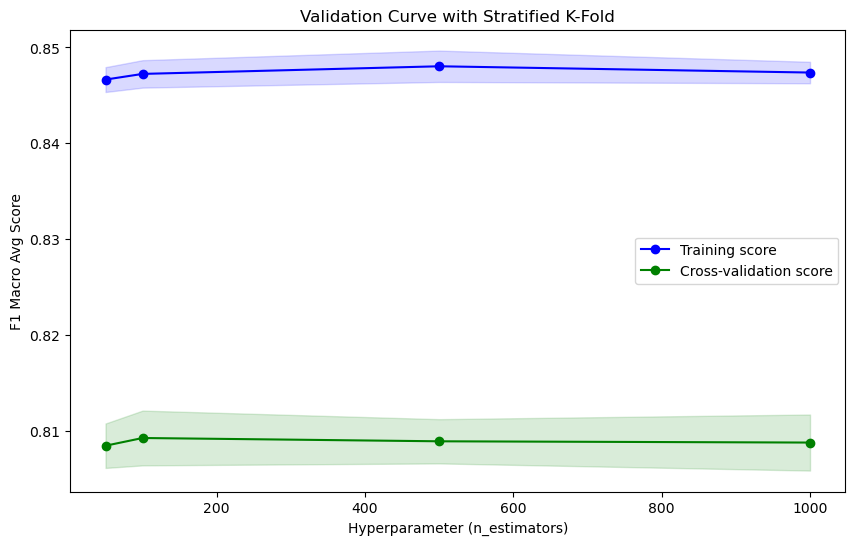

In [14]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training score", color="blue", marker="o")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")

plt.plot(param_range, test_mean, label="Cross-validation score", color="green", marker="o")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color="green")

plt.title("Validation Curve with Stratified K-Fold")
plt.xlabel("Hyperparameter (n_estimators)")
plt.ylabel("F1 Macro Avg Score")
plt.legend(loc="best")
plt.show()

In [15]:
model = RandomForestClassifier()

param_range = [20, 15, 10, 5]

# macro_f1_scorer = make_scorer(f1_score, average='macro')
# cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

train_scores, test_scores = validation_curve(
    model, X_train, y_train, param_name="max_depth", param_range=param_range,
    cv=stratified_cv, scoring=macro_f1_scorer, n_jobs=-1)

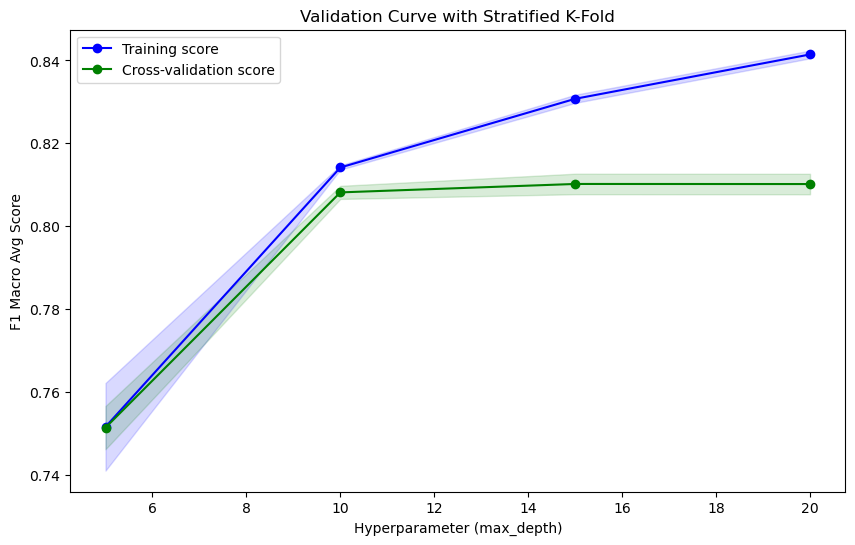

In [16]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training score", color="blue", marker="o")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")

plt.plot(param_range, test_mean, label="Cross-validation score", color="green", marker="o")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color="green")

plt.title("Validation Curve with Stratified K-Fold")
plt.xlabel("Hyperparameter (max_depth)")
plt.ylabel("F1 Macro Avg Score")
plt.legend(loc="best")
plt.show()

### Randomized Search

In [17]:
# Number of trees in random forest
n_estimators = [200,500,800,1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [15, 20, 25, 30]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 500, 800, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [15, 20, 25, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [18]:
# First create the base model to tune
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = stratified_cv, random_state=42, n_jobs = -1,scoring=macro_f1_scorer)

# Fit the random search model
rf_random.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [15, 20, 25, 30, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 500, 800, 1000]},
                   random_state=42,
                   scoring=make_scorer(f1_score, average=macro))

In [19]:
random_best_params_rf = rf_random.best_params_
random_best_score_rf = rf_random.best_score_
print("Best parameters values for Randomized Search: \n",random_best_params_rf)

Best parameters values for Randomized Search: 
 {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}


### Grid Search

In [20]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [18, 20, 22],
    'max_features': ['auto'],
    'min_samples_leaf': [1,2],
    'min_samples_split': [5, 6,7],
    'n_estimators': [750, 800, 850, 900]
}
# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, n_jobs = -1, cv = stratified_cv,scoring=macro_f1_scorer)
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [18, 20, 22],
                         'max_features': ['auto'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [5, 6, 7],
                         'n_estimators': [750, 800, 850, 900]},
             scoring=make_scorer(f1_score, average=macro))

### Best Parameter Configuration

In [21]:
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_
print("Best parameters values for Grid Search: \n",best_params_rf)
print("Weight of this model: \n",best_score_rf)

Best parameters values for Grid Search: 
 {'bootstrap': True, 'max_depth': 18, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 800}
Weight of this model: 
 0.811445179110929


# Support Vector Machine

### Default Parameter Configuration

In [33]:
svm_classifier = SVC()

svm_classifier.fit(X_train, y_train)

y_pred_train_svm = svm_classifier.predict(X_train)

y_pred_svm = svm_classifier.predict(X_test)

print("Classification Report (Training):\n", classification_report(y_train, y_pred_train_svm))

print("Classification Report (Test):\n", classification_report(y_test,y_pred_svm))

Classification Report (Training):
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      4526
           1       0.98      0.91      0.94      4295
           2       0.83      0.94      0.88      4742
           3       0.73      0.51      0.60      4729
           4       0.98      0.78      0.87      4664
           5       0.84      0.72      0.78       789
           6       0.99      0.99      0.99      4787
           7       0.71      0.89      0.79      4776
           8       1.00      0.42      0.60      4384
           9       0.62      1.00      0.77      4209
          10       0.48      0.91      0.63      4701
          11       0.56      0.15      0.24      4789

    accuracy                           0.77     51391
   macro avg       0.81      0.77      0.75     51391
weighted avg       0.80      0.77      0.75     51391

Classification Report (Test):
               precision    recall  f1-score   support

           0

In [34]:
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print(f'Confusion Matrix (Test):\n{conf_matrix_svm}')

Confusion Matrix (Test):
[[1115    0    0    0    0    9    7    0    0    1    0    0]
 [   6  955    0    8   13   26    4   61    0    0    0    1]
 [   0    0 1118   49    1    0    0   18    0    0    0    0]
 [   0    4  192  627    7    0    0  352    0    0    0    0]
 [   0    0    0   23  898    0    0   20    0    0  180   45]
 [  40    0    0    0    0  146    0    0    0   11    0    0]
 [   0    6    0    0    0    0 1189    0    0    0    2    0]
 [   0    7    3  127    1    0    1 1055    0    0    0    0]
 [   1    0    0    0    0    0    0    0  458  637    0    0]
 [   0    0    0    0    0    0    1    0    0 1051    0    0]
 [   0    0    0    0    0    0    0    1    0    0 1078   96]
 [   0    0    0    0    2    0    0    0    0    0 1042  153]]


### Validation Curve

In [ ]:
model = SVC()

param_range =  ["rbf","linear", "poly"]

stratified_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
macro_f1_scorer = make_scorer(f1_score, average='macro')

train_scores, test_scores = validation_curve(
    model, X_train, y_train, param_name="kernel", param_range=param_range,
    cv=stratified_cv, scoring=macro_f1_scorer, n_jobs=-1)

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training score", color="blue", marker="o")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")

plt.plot(param_range, test_mean, label="Cross-validation score", color="green", marker="o")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color="green")

plt.title("Validation Curve with Stratified K-Fold")
plt.xlabel("Hyperparameter (kernel)")
plt.ylabel("Macro F1 avg Score")
plt.legend(loc="best")
plt.show()

In [35]:
model = SVC() #default kernel="RBF"

param_range =  [100, 300, 400]

train_scores, test_scores = validation_curve(
    model, X_train, y_train, param_name="C", param_range=param_range,
    cv=stratified_cv, scoring=macro_f1_scorer, n_jobs=-1)

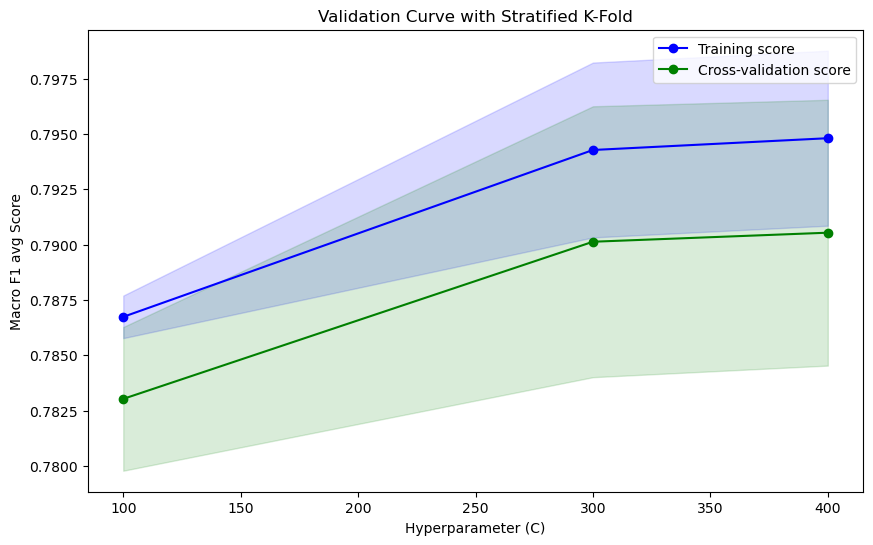

In [36]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training score", color="blue", marker="o")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")

plt.plot(param_range, test_mean, label="Cross-validation score", color="green", marker="o")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color="green")

plt.title("Validation Curve with Stratified K-Fold")
plt.xlabel("Hyperparameter (C)")
plt.ylabel("Macro F1 avg Score")
plt.legend(loc="best")
plt.show()

In [12]:
model = SVC(kernel="rbf")

param_range =  [100,10,0.1]

train_scores, test_scores = validation_curve(
    model, X_train, y_train, param_name="gamma", param_range=param_range,
    cv=stratified_cv, scoring=macro_f1_scorer, n_jobs=-1)

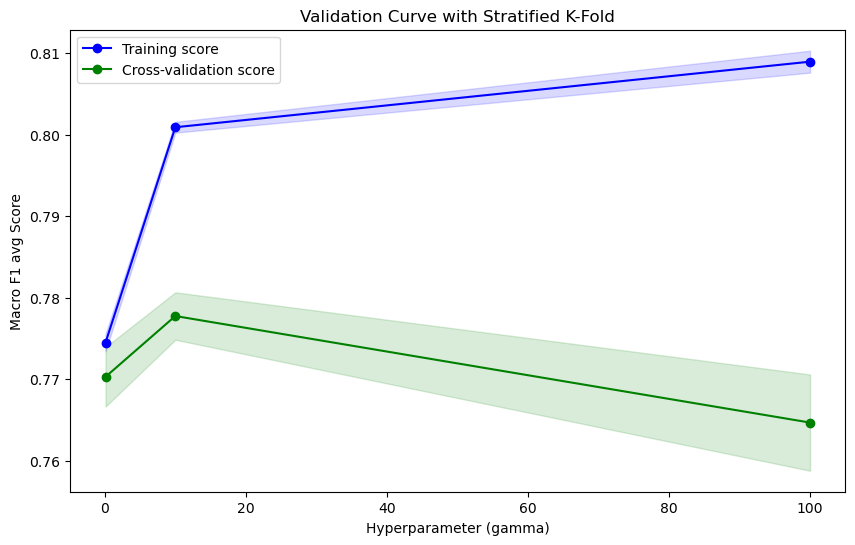

In [13]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training score", color="blue", marker="o")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")

plt.plot(param_range, test_mean, label="Cross-validation score", color="green", marker="o")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color="green")

plt.title("Validation Curve with Stratified K-Fold")
plt.xlabel("Hyperparameter (gamma)")
plt.ylabel("Macro F1 avg Score")
plt.legend(loc="best")
plt.show()

### Randomized Search

In [ ]:
random_grid = {
    'C': [300,375,450],
    'gamma': [5,10,15]
}
print(random_grid)

In [15]:
# First create the base model to tune
model =  SVC(kernel = 'rbf')

svm_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 4, cv = stratified_cv, random_state=42, n_jobs = -1,scoring=macro_f1_scorer)

# Fit the random search model
svm_random.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=SVC(), n_iter=4, n_jobs=-1,
                   param_distributions={'C': [300, 375, 450],
                                        'gamma': [5, 10, 15]},
                   random_state=42,
                   scoring=make_scorer(f1_score, average=macro))

In [16]:
random_best_score_svm = svm_random.best_score_
random_best_params_svm = svm_random.best_params_
print("Best parameters values for Randomized Search: \n",random_best_params_svm)

Best parameters values for Randomized Search: 
 {'gamma': 5, 'C': 300}


### Grid Search

In [17]:
model =  SVC(kernel = 'rbf')

param_grid= parameter={'C': [300, 325, 350],
    'gamma': [3, 5, 7],}

# Instantiate the grid search model
grid_search_svm = GridSearchCV(estimator = model, param_grid = param_grid,n_jobs = -1, cv = stratified_cv, scoring=macro_f1_scorer)
grid_search_svm.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [300, 325, 350], 'gamma': [3, 5, 7]},
             scoring=make_scorer(f1_score, average=macro))

### Best Parameter Configuration

In [18]:
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_
print("Best parameters values for Grid Search: \n",best_params_svm)
print("Weight of this model: \n",best_score_svm)

Best parameters values for Grid Search: 
 {'C': 350, 'gamma': 3}
Weight of this model: 
 0.7920232972101876


# Logistic Regression

### Default Parameter Configuration

In [11]:
# Create a Logistic Regression classifier
lr_classifier = LogisticRegression()

# Train the classifier on the training data
lr_classifier.fit(X_train, y_train)

# Make predictions on the training set
y_pred_train_lr = lr_classifier.predict(X_train)

# Make predictions on the test set
y_pred_lr = lr_classifier.predict(X_test)

print("Classification Report (Training):\n", classification_report(y_train, y_pred_train_lr))

print("Classification Report (Test):\n", classification_report(y_test, y_pred_lr))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Classification Report (Training):
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      4526
           1       0.98      0.90      0.94      4295
           2       0.83      0.94      0.88      4742
           3       0.76      0.50      0.61      4729
           4       0.97      0.89      0.93      4664
           5       0.64      0.65      0.64       789
           6       0.99      1.00      0.99      4787
           7       0.70      0.90      0.79      4776
           8       1.00      0.42      0.60      4384
           9       0.62      1.00      0.77      4209
          10       0.50      0.76      0.60      4701
          11       0.54      0.30      0.39      4789

    accuracy                           0.77     51391
   macro avg       0.79      0.77      0.76     51391
weighted avg       0.80      0.77      0.76     51391

Classification Report (Test):
               precision    recall  f1-score   support

           0

In [12]:
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
print(f'Confusion Matrix (Test):\n{conf_matrix_lr}')

Confusion Matrix (Test):
[[1058    4    1    0    0   60    7    0    1    1    0    0]
 [   5  954    0    9   13   25    6   60    0    1    0    1]
 [   0    0 1118   49    1    0    0   18    0    0    0    0]
 [   0    4  192  627    8    0    0  351    0    0    0    0]
 [   0    0    0   16 1021    0    0   19    0    0   76   34]
 [  49    0    0    0    0  139    0    0    0    9    0    0]
 [   0    4    0    0    0    0 1191    0    0    0    2    0]
 [   0    6    4  110    9    0    0 1064    0    0    1    0]
 [   0    0    0    0    0    0    0    0  459  637    0    0]
 [   0    0    0    0    0    0    1    0    0 1051    0    0]
 [   0    0    0    0    1    0    0    1    0    0  886  287]
 [   0    0    0    0    3    0    0    0    0    0  843  351]]


### Validation Curve

In [13]:
model = LogisticRegression()

param_range = ["ovr", "multinomial"]

train_scores, test_scores = validation_curve(
    model, X_train, y_train, param_name="multi_class", param_range=param_range,
    cv=stratified_cv, scoring=macro_f1_scorer, n_jobs=-1)

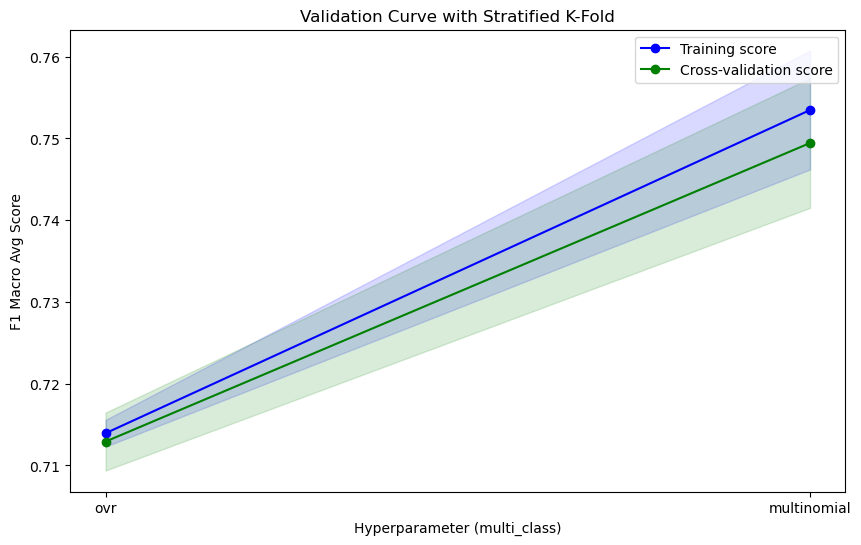

In [14]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training score", color="blue", marker="o")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")

plt.plot(param_range, test_mean, label="Cross-validation score", color="green", marker="o")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color="green")

plt.title("Validation Curve with Stratified K-Fold")
plt.xlabel("Hyperparameter (multi_class)")
plt.ylabel("F1 Macro Avg Score")
plt.legend(loc="best")
plt.show()

In [37]:
model = LogisticRegression(multi_class="ovr")

param_range = ["newton-cg", "sag","liblinear"]


train_scores, test_scores = validation_curve(
    model, X_train, y_train, param_name="solver", param_range=param_range,
    cv=stratified_cv, scoring=macro_f1_scorer, n_jobs=-1)

In [38]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training score", color="blue", marker="o")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")

plt.plot(param_range, test_mean, label="Cross-validation score", color="green", marker="o")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color="green")

plt.title("Validation Curve with Stratified K-Fold")
plt.xlabel("Hyperparameter (solver)")
plt.ylabel("F1 Macro Avg Score")
plt.legend(loc="best")
plt.show()

In [15]:
# l1 penalty with standard solver and multi_class="multinomial" is not allowed
# We dont use lbfgs since it fails to converge
model = LogisticRegression(multi_class="multinomial")

param_range = ["newton-cg", "sag","saga"]

train_scores, test_scores = validation_curve(
    model, X_train, y_train, param_name="solver", param_range=param_range,
    cv=stratified_cv, scoring=macro_f1_scorer, n_jobs=-1)

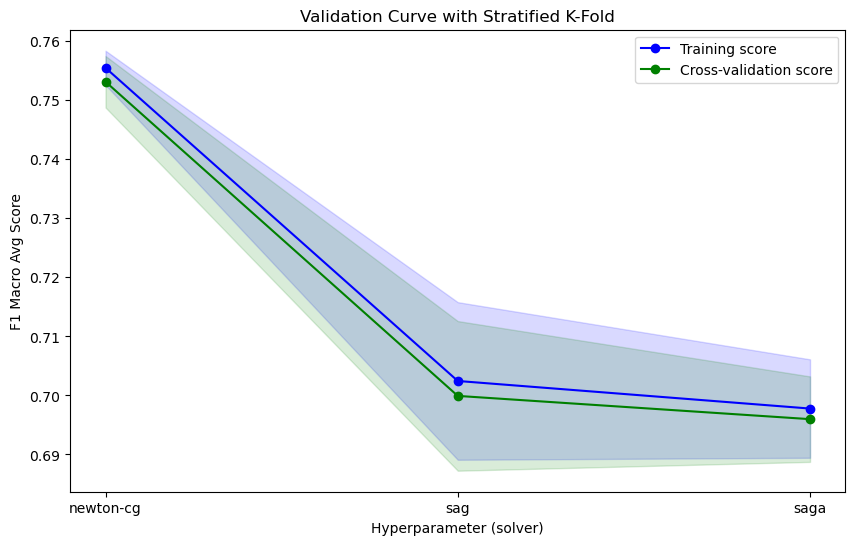

In [16]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training score", color="blue", marker="o")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")

plt.plot(param_range, test_mean, label="Cross-validation score", color="green", marker="o")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color="green")

plt.title("Validation Curve with Stratified K-Fold")
plt.xlabel("Hyperparameter (solver)")
plt.ylabel("F1 Macro Avg Score")
plt.legend(loc="best")
plt.show()

In [17]:
model = LogisticRegression(multi_class="multinomial")

param_range = [1000, 100, 10, 1]

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

train_scores, test_scores = validation_curve(
    model, X_train, y_train, param_name="C", param_range=param_range,
    cv=cv, scoring=macro_f1_scorer, n_jobs=-1)

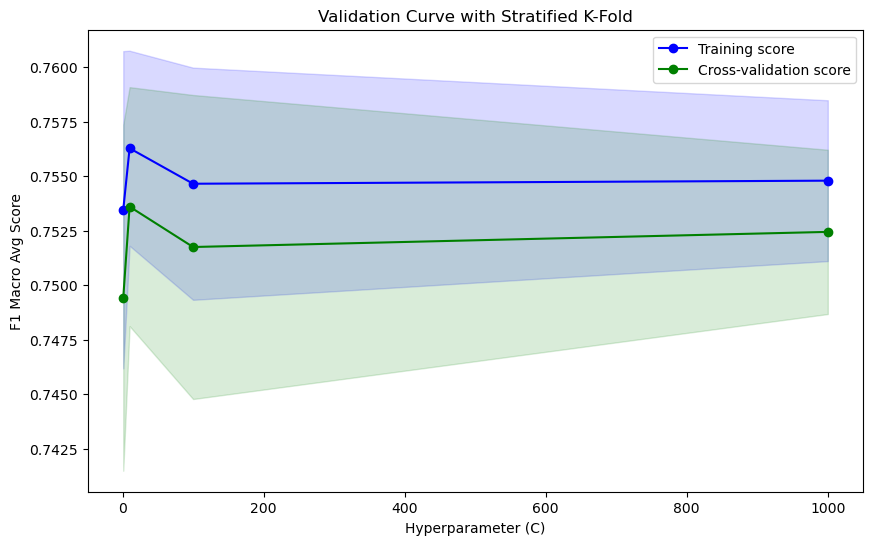

In [18]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training score", color="blue", marker="o")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")

plt.plot(param_range, test_mean, label="Cross-validation score", color="green", marker="o")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color="green")

plt.title("Validation Curve with Stratified K-Fold")
plt.xlabel("Hyperparameter (C)")
plt.ylabel("F1 Macro Avg Score")
plt.legend(loc="best")
plt.show()

### Random Search

In [34]:
solvers = ['newton-cg', 'sag']
c_values = [100, 10, 1.0, 0.1]

# Create the random grid
random_grid = { 'solver': solvers,
               'C': c_values,
              }
print(random_grid)

{'solver': ['newton-cg', 'sag'], 'C': [100, 10, 1.0, 0.1]}


In [ ]:
# First create the base model to tune
model = LogisticRegression(multi_class="multinomial",max_iter=1000)

lr_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 4, cv = stratified_cv, random_state=42, n_jobs = -1,scoring=macro_f1_scorer)

# Fit the random search model
lr_random.fit(X_train,y_train)

### Best Parameter Configuration

In [38]:
best_params_lr = lr_random.best_params_
best_score_lr = lr_random.best_score_
print("Best parameters values for Grid Search: \n",best_params_lr)
print("Weight of this model: \n",best_score_lr)

Best parameters values for Grid Search: 
 {'solver': 'newton-cg', 'C': 100}
Weight of this model: 
 0.757771587384698


# K-Nearest Neighbors

### Default Parameter Configuration

In [45]:
# Create a KNN classifier
knn_classifier = KNeighborsClassifier()

# Train the classifier on the training data
knn_classifier.fit(X_train, y_train)

# Make predictions on the training set
y_pred_train_knn = knn_classifier.predict(X_train)

# Make predictions on the test set
y_pred_knn = knn_classifier.predict(X_test)

print("Classification Report (Training):\n", classification_report(y_train, y_pred_train_knn))

print("Classification Report (Test):\n", classification_report(y_test, y_pred_knn))

Classification Report (Training):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      4526
           1       0.97      0.92      0.95      4295
           2       0.84      0.91      0.87      4742
           3       0.81      0.62      0.70      4729
           4       0.98      0.97      0.98      4664
           5       0.89      0.96      0.92       789
           6       1.00      1.00      1.00      4787
           7       0.78      0.94      0.86      4776
           8       0.69      0.67      0.68      4384
           9       0.67      0.69      0.68      4209
          10       0.63      0.60      0.61      4701
          11       0.62      0.65      0.63      4789

    accuracy                           0.82     51391
   macro avg       0.82      0.83      0.82     51391
weighted avg       0.82      0.82      0.82     51391

Classification Report (Test):
               precision    recall  f1-score   support

           0

In [46]:
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print(f'Confusion Matrix (Test):\n{conf_matrix_knn}')

Confusion Matrix (Test):
[[1119    2    0    0    0    7    2    0    0    2    0    0]
 [   3  962    1   10    8   27    4   57    0    1    0    1]
 [   0    0 1086   86    1    0    0   13    0    0    0    0]
 [   0    4  182  728    6    0    0  262    0    0    0    0]
 [   0    2    0   17 1123    0    0   16    0    0    2    6]
 [   7    4    0    0    0  186    0    0    0    0    0    0]
 [   0    3    0    0    0    0 1193    0    0    0    1    0]
 [   0   12    3   51   11    0    0 1117    0    0    0    0]
 [   0    0    0    0    0    0    0    0  722  374    0    0]
 [   0    0    0    0    0    0    1    0  346  705    0    0]
 [   0    0    0    0    1    0    0    1    0    0  612  561]
 [   0    0    0    0    2    0    0    0    0    0  562  633]]


### Validation Curve

In [47]:
model = KNeighborsClassifier()

param_range = [ 5, 10, 15, 20]

train_scores, test_scores = validation_curve(
    model, X_train, y_train, param_name="n_neighbors", param_range=param_range,
    cv=stratified_cv, scoring=macro_f1_scorer, n_jobs=-1)

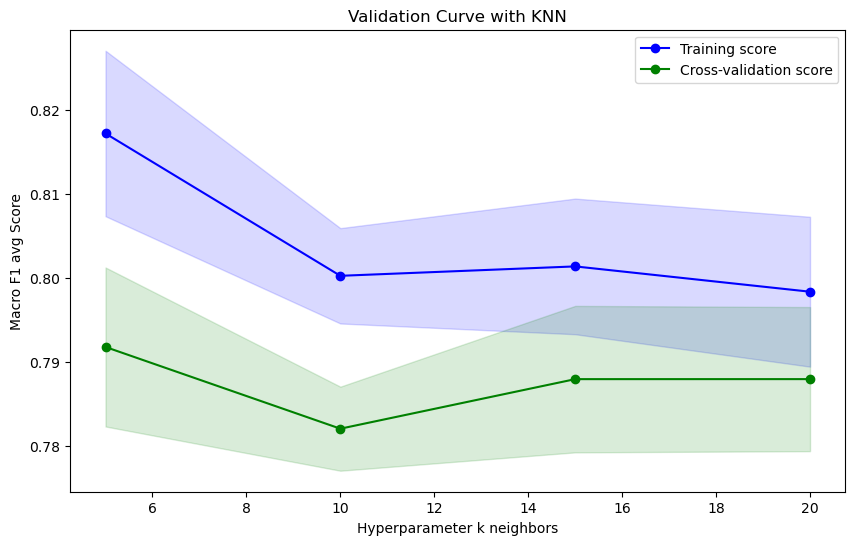

In [48]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training score", color="blue", marker="o")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color="blue")

plt.plot(param_range, test_mean, label="Cross-validation score", color="green", marker="o")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color="green")

plt.title("Validation Curve with KNN")
plt.xlabel("Hyperparameter k neighbors")
plt.ylabel("Macro F1 avg Score")
plt.legend(loc="best")
plt.show()

### Randomized Search

In [49]:
random_grid= parameter={'n_neighbors': np.arange(3, 50, 4),
                        'metric': ['euclidean', 'manhattan', 'chebyshev']}
print(random_grid)

{'n_neighbors': array([ 3,  7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47]), 'metric': ['euclidean', 'manhattan', 'chebyshev']}


In [50]:
# First create the base model to tune
model = KNeighborsClassifier()

knn_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 20, cv = stratified_cv, random_state=42, n_jobs = -1,scoring=macro_f1_scorer)

# Fit the random search model
knn_random.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=KNeighborsClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'chebyshev'],
                                        'n_neighbors': array([ 3,  7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47])},
                   random_state=42,
                   scoring=make_scorer(f1_score, average=macro))

In [51]:
random_best_params_knn = knn_random.best_params_
random_best_score_knn = knn_random.best_score_
print("Best parameters values for Randomized Search: \n",random_best_params_knn)

Best parameters values for Randomized Search: 
 {'n_neighbors': 3, 'metric': 'manhattan'}


### Grid Search

In [52]:
model = KNeighborsClassifier(metric =  'manhattan')

# Create the parameter grid based on the results of random search 
param_grid = {
    'n_neighbors': [3, 5, 7, 9]
}

# Instantiate the grid search model
grid_search_knn = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = -1, scoring=macro_f1_scorer, cv = stratified_cv)
grid_search_knn.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(metric='manhattan'), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9]},
             scoring=make_scorer(f1_score, average=macro))

### Best Parameter Configuration

In [53]:
best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_
print("Best parameters values for Grid Search: \n",best_params_knn)
print("Weight of this model: \n",best_score_knn)

Best parameters values for Grid Search: 
 {'n_neighbors': 3}
Weight of this model: 
 0.8039361338011974


# Ensemble Technique

**Voting classifiers** are a type of ensemble learning method that combines the predictions of multiple individual models (classifiers) to make a final prediction. 

When there is a tie or parity in the number of votes for different classes, we will consider the weights of the models, that is the scoring metric we used in Grid Search, the macro-average F1 score.

In [61]:

def create_vector1(v1, v2, v3, v4, weights,i):
    result_vector = np.zeros(12)
    result_vector[v1] += weights[0]
    result_vector[v2] += weights[1]
    result_vector[v3] += weights[2]
    result_vector[v4] += weights[3]
    print(f"Tie Vote: {v1} {v2} {v3} {v4}, Index of sample in Test Set {i}")
    return np.argmax(result_vector)

def create_vector(vectors, weights):
    i=0
    result_vector = np.zeros(12)
    recurring_numbers = []
    tie_vote=[]

    for v1, v2, v3, v4 in zip(*vectors):
        result_vector[v1] += 1
        result_vector[v2] += 1
        result_vector[v3] += 1
        result_vector[v4] += 1

        if np.count_nonzero(result_vector == np.max(result_vector)) == 1:
            recurring_numbers.append(np.argmax(result_vector))
        else:
            recurring_numbers.append(create_vector1(v1, v2, v3, v4, weights,i))
            tie_vote.append(i)

        result_vector = np.zeros(12)
        i +=1

    return recurring_numbers, tie_vote

In [12]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(bootstrap= True, max_depth=18,max_features="auto", min_samples_leaf=1, min_samples_split=7, n_estimators=800)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

best_score_rf= 0.811445179110929

In [13]:
# Create a KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3,metric =  'manhattan')

# Train the classifier on the training data
knn_classifier.fit(X_train, y_train)

best_score_knn =  0.804

In [14]:
# Create an SVM classifier
svm_classifier = SVC(C=350, gamma=3,kernel='rbf')

# Train the classifier on the training data
svm_classifier.fit(X_train, y_train)

best_score_svm = 0.7920232972101876

In [ ]:
# Create a Logistic Regression classifier
lr_classifier = LogisticRegression(multi_class='multinomial',solver='newton-cg', penalty='l2', C=100, max_iter=1000)

# Train the classifier on the training data
lr_classifier.fit(X_train, y_train)

best_score_lr = 0.757771587384698

### Ensemble Predictions

In [16]:
# Make predictions on training set
pred_train_knn = knn_classifier.predict(X_train)
pred_train_rf = rf_classifier.predict(X_train)
pred_train_svm = svm_classifier.predict(X_train)
pred_train_lr = lr_classifier.predict(X_train)

# Make predictions on the test set
pred_knn = knn_classifier.predict(X_test)
pred_rf = rf_classifier.predict(X_test)
pred_svm = svm_classifier.predict(X_test)
pred_lr = lr_classifier.predict(X_test)

weights = [best_score_knn, best_score_rf, best_score_svm, best_score_lr]

print("Weights:", weights)
tie_vot=[]

# Combine predictions on the training set
vectors_train = (pred_train_knn, pred_train_rf, pred_train_svm, pred_train_lr)
y_pred_train_ensemble, tie_vot = create_vector(vectors_train, weights) 

# Combine predictions on the test set
vectors_test = (pred_knn, pred_rf, pred_svm, pred_lr)
y_pred_ensemble, tie_vot = create_vector(vectors_test, weights) 

print("Classification Report (Training):\n", classification_report(y_train, y_pred_train_ensemble))

print("Classification Report (Test):\n", classification_report(y_test, y_pred_ensemble))

Weights: [0.804, 0.811445179110929, 0.7920232972101876, 0.757771587384698]
Classification Report (Training):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4526
           1       0.99      0.92      0.96      4295
           2       0.84      0.94      0.89      4742
           3       0.86      0.59      0.70      4729
           4       0.98      0.97      0.98      4664
           5       0.93      1.00      0.96       789
           6       1.00      1.00      1.00      4787
           7       0.77      0.97      0.86      4776
           8       0.97      0.47      0.63      4384
           9       0.64      0.99      0.78      4209
          10       0.60      0.67      0.63      4701
          11       0.63      0.56      0.59      4789

    accuracy                           0.83     51391
   macro avg       0.85      0.84      0.83     51391
weighted avg       0.84      0.83      0.82     51391

Classification Report (

In [17]:
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)
print(f'Confusion Matrix (Test):\n{conf_matrix_ensemble}')

Confusion Matrix (Test):
[[1130    0    0    0    0    2    0    0    0    0    0    0]
 [   3  963    0   11    9   27    1   58    0    2    0    0]
 [   0    0 1116   56    1    0    0   13    0    0    0    0]
 [   0    4  195  691    8    0    0  284    0    0    0    0]
 [   0    0    0   12 1130    0    0   18    0    0    4    2]
 [   3    1    0    0    0  193    0    0    0    0    0    0]
 [   0    0    0    0    0    0 1196    0    0    0    1    0]
 [   1    4    3   37    6    0    0 1143    0    0    0    0]
 [   0    0    0    0    0    0    0    0  478  618    0    0]
 [   0    0    0    0    0    0    0    0   33 1019    0    0]
 [   0    0    0    0    1    0    0    1    0    0  724  449]
 [   0    0    0    0    3    0    0    0    0    0  617  577]]


###  Performance of Individual Models

In [123]:
print("Random Forest")
print("Classification Report (Training):\n", classification_report(y_train, pred_train_rf))

print("Classification Report (Test):\n", classification_report(y_test, pred_rf))

Random Forest
Classification Report (Training):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4526
           1       0.99      0.92      0.96      4295
           2       0.84      0.94      0.89      4742
           3       0.86      0.59      0.70      4729
           4       0.98      0.97      0.98      4664
           5       0.92      1.00      0.96       789
           6       1.00      1.00      1.00      4787
           7       0.77      0.97      0.86      4776
           8       0.97      0.47      0.63      4384
           9       0.64      0.99      0.78      4209
          10       0.59      0.66      0.62      4701
          11       0.62      0.54      0.58      4789

    accuracy                           0.82     51391
   macro avg       0.85      0.84      0.83     51391
weighted avg       0.84      0.82      0.82     51391

Classification Report (Test):
               precision    recall  f1-score   support

In [124]:
print("k-Nearest Neighbors")
print("Classification Report (Training):\n", classification_report(y_train, pred_train_knn))

print("Classification Report (Test):\n", classification_report(y_test, pred_knn))

k-Nearest Neighbors
Classification Report (Training):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4526
           1       0.98      0.92      0.95      4295
           2       0.86      0.91      0.88      4742
           3       0.71      0.80      0.75      4729
           4       0.98      0.97      0.98      4664
           5       0.91      0.98      0.94       789
           6       1.00      1.00      1.00      4787
           7       0.89      0.78      0.83      4776
           8       0.82      0.55      0.66      4384
           9       0.65      0.87      0.74      4209
          10       0.64      0.67      0.66      4701
          11       0.66      0.63      0.65      4789

    accuracy                           0.83     51391
   macro avg       0.84      0.84      0.84     51391
weighted avg       0.84      0.83      0.83     51391

Classification Report (Test):
               precision    recall  f1-score   s

In [125]:
print("Support Vector Machine")
print("Classification Report (Training):\n", classification_report(y_train, pred_train_svm))

print("Classification Report (Test):\n", classification_report(y_test, pred_svm))

Support Vector Machine
Classification Report (Training):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4526
           1       0.99      0.92      0.96      4295
           2       0.84      0.94      0.88      4742
           3       0.84      0.56      0.68      4729
           4       0.98      0.94      0.96      4664
           5       0.94      1.00      0.97       789
           6       1.00      1.00      1.00      4787
           7       0.75      0.96      0.84      4776
           8       0.98      0.44      0.61      4384
           9       0.63      0.99      0.77      4209
          10       0.52      0.60      0.56      4701
          11       0.54      0.47      0.51      4789

    accuracy                           0.80     51391
   macro avg       0.83      0.82      0.81     51391
weighted avg       0.83      0.80      0.80     51391

Classification Report (Test):
               precision    recall  f1-score 

In [126]:
print("Logistic Regression")
print("Classification Report (Training):\n", classification_report(y_train, pred_train_lr))

print("Classification Report (Test):\n", classification_report(y_test, pred_lr))

Logistic Regression
Classification Report (Training):
               precision    recall  f1-score   support

           0       0.94      0.95      0.95      4526
           1       0.98      0.90      0.94      4295
           2       0.83      0.94      0.88      4742
           3       0.77      0.50      0.61      4729
           4       0.97      0.91      0.94      4664
           5       0.64      0.66      0.65       789
           6       0.99      0.99      0.99      4787
           7       0.71      0.91      0.79      4776
           8       1.00      0.42      0.60      4384
           9       0.62      1.00      0.77      4209
          10       0.52      0.64      0.57      4701
          11       0.50      0.41      0.45      4789

    accuracy                           0.78     51391
   macro avg       0.79      0.77      0.76     51391
weighted avg       0.80      0.78      0.77     51391

Classification Report (Test):
               precision    recall  f1-score   s

### Investigation on False Positive and False Negative

In [64]:
differing_indices = [i for i, (x, y) in enumerate(zip(y_pred_ensemble, y_test)) if x != y]

print("Number of errors in predictions:", len(differing_indices))
tie_votes=[]
y_pred_ensemble, tie_votes = create_vector(vectors_test, weights) 

Number of errors in predictions: 2488
Tie Vote: 8 8 9 9, Index of sample in Test Set 74
Tie Vote: 7 3 7 3, Index of sample in Test Set 86
Tie Vote: 10 10 11 11, Index of sample in Test Set 92
Tie Vote: 11 11 10 10, Index of sample in Test Set 100
Tie Vote: 10 10 11 11, Index of sample in Test Set 119
Tie Vote: 11 11 10 10, Index of sample in Test Set 142
Tie Vote: 10 11 11 10, Index of sample in Test Set 190
Tie Vote: 11 11 10 10, Index of sample in Test Set 206
Tie Vote: 11 11 10 10, Index of sample in Test Set 207
Tie Vote: 4 4 7 7, Index of sample in Test Set 219
Tie Vote: 8 8 9 9, Index of sample in Test Set 222
Tie Vote: 10 11 11 10, Index of sample in Test Set 238
Tie Vote: 11 10 11 10, Index of sample in Test Set 274
Tie Vote: 11 11 10 10, Index of sample in Test Set 304
Tie Vote: 10 11 11 10, Index of sample in Test Set 323
Tie Vote: 11 11 10 10, Index of sample in Test Set 329
Tie Vote: 10 10 11 11, Index of sample in Test Set 331
Tie Vote: 11 11 10 10, Index of sample in Test

In [88]:
tie_votes_wrong=[]
for sample in tie_votes:
    if sample in differing_indices:
        tie_votes_wrong.append(y_test.index[sample])
print("Tie votes that resulted in a wrong prediction :")
print(sorted(tie_votes_wrong))

Tie votes that resulted in a wrong prediction :
[2003, 6035, 6580, 7199, 8631, 9551, 10048, 10055, 11717, 14183, 15253, 16005, 16346, 16377, 17385, 17386, 17407, 17559, 18881, 20024, 20178, 22180, 22959, 27263, 27485, 36852, 37303, 37537, 38609, 39336, 39387, 39861, 40038, 41125, 41152, 41549, 42020, 42049, 42056, 42064, 42089, 42094, 42113, 42130, 42131, 42138, 42142, 42193, 42202, 42230, 42257, 42306, 42317, 42362, 42372, 42407, 42409, 42420, 42432, 42439, 42507, 42523, 42526, 42534, 42573, 42583, 42586, 42592, 42630, 42693, 42694, 42695, 42711, 42718, 42727, 42747, 42778, 42794, 42804, 42868, 42869, 42924, 42993, 43013, 43060, 43072, 43084, 43092, 43149, 43171, 43277, 43282, 43294, 43359, 43433, 43446, 43461, 43520, 43533, 43536, 43567, 43600, 43648, 43703, 43732, 43874, 43886, 43895, 43933, 43954, 43962, 44036, 44097, 44311, 44380, 44431, 44527, 44539, 44698, 44828, 44829, 44892, 44989, 45021, 45075, 45087, 45260, 45481, 45553, 45556, 45582, 45614, 45680, 45784, 45785, 45870, 45892

In [89]:
notable_samples_position = [92,222,12153]

for i in notable_samples_position:
    print(f"Sample index {y_test.index[i]}, Label {y_test.values[i]}, Prediction {y_pred_ensemble[i]}")

Sample index 62920, Label 11, Prediction 10
Sample index 54750, Label 9, Prediction 8
Sample index 41152, Label 7, Prediction 3


In [58]:
df_final = pd.concat([X_train, y_train], axis=1)
mask = (df_final["label"]==8) | (df_final["label"]==9)
df_89 = df_final[mask]
df_89label = df_89["label"]
df_89 = df_89.drop("label",axis=1)

In [59]:
random_forest_model = RandomForestClassifier()

random_forest_model.fit(df_89, df_89label)

feature_importance = random_forest_model.feature_importances_

In [60]:
sorted_indices = np.argsort(feature_importance)

print("Feature Importance in ascending order: ")
for index in sorted_indices:
    print(f"{df_89.columns[index]}: {feature_importance[index]}")

Feature Importance in ascending order: 
 Destination Port_443: 0.0
 Fwd Header Length.1: 0.0
 Source Port_80: 0.0
 URG Flag Count: 0.0
 SYN Flag Count: 0.0
 Packet Length Std: 0.0
 Source Port_443: 0.0
 Source Port_512: 0.0
 Source Port_530: 0.0
 min_seg_size_forward: 0.0
 Source Port_648: 0.0
 Source Port_672: 0.0
 Source Port_678: 0.0
 Source Port_900: 0.0
 Destination Port_22: 0.0
 Bwd Packet Length Min: 0.0
 Fwd Packet Length Std: 0.0
 Destination Port_53: 0.0
Fwd PSH Flags: 0.0
 Destination Port_80: 0.0
 Destination Port_-1: 4.6740956322509534e-05
 Max Packet Length: 6.510152154217189e-05
Init_Win_bytes_forward: 7.046631884191949e-05
Total Length of Fwd Packets: 8.045673221316954e-05
 Destination Port_0: 8.486697367361077e-05
 Min Packet Length: 8.587310289417919e-05
Protocol_17: 0.00011023994630338426
 Source Port_-1: 0.00017404300306749485
 Source Port_61850: 0.00018622918738151232
 Bwd IAT Std: 0.005838682297818643
 Down/Up Ratio: 0.007525313583882329
Bwd IAT Total: 0.008495371

In [62]:
mask = (df_processed["label"]==8) | (df_processed["label"]==9)
df_89 = df_processed[mask]

<AxesSubplot:xlabel='label', ylabel=' Flow IAT Max'>

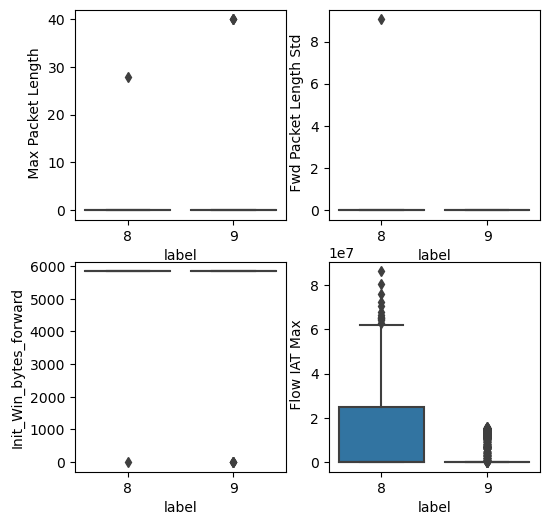

In [65]:
fig,ax = plt.subplots(2,2,figsize=(6,6))
sns.boxplot(data = df_89,y = ' Max Packet Length',x = 'label',ax=ax[0,0])
sns.boxplot(data = df_89,y = ' Fwd Packet Length Std',x = 'label',ax=ax[0,1])
sns.boxplot(data = df_89,y = 'Init_Win_bytes_forward',x = 'label',ax=ax[1,0])
sns.boxplot(data = df_89,y = ' Flow IAT Max',x = 'label',ax=ax[1,1])

In [18]:
df_final = pd.concat([X_train, y_train], axis=1)
mask = (df_final["label"]==3) | (df_final["label"]==7)
df_37 = df_final[mask]
df_37label = df_37["label"]
df_37 = df_37.drop("label",axis=1)

In [19]:
random_forest_model = RandomForestClassifier()

random_forest_model.fit(df_37, df_37label)

feature_importance = random_forest_model.feature_importances_

In [20]:
sorted_indices = np.argsort(feature_importance)

print("Feature Importance in ascending order: ")
for index in sorted_indices:
    print(f"{df_37.columns[index]}: {feature_importance[index]}")

Feature Importance in ascending order: 
 Destination Port_53: 0.0
 Bwd Packet Length Min: 0.0
 Down/Up Ratio: 0.0
 Source Port_61850: 0.0
 Source Port_80: 0.0
 Source Port_443: 0.0
 Fwd Packet Length Std: 6.503143203045644e-06
Fwd PSH Flags: 8.113682880127953e-06
 Bwd IAT Min: 1.2929768276616036e-05
 SYN Flag Count: 1.4741421254234874e-05
 Destination Port_0: 2.1999596795338914e-05
 Destination Port_80: 2.342420335991465e-05
 Bwd Packets/s: 2.6073207133456813e-05
 Bwd Header Length: 3.263570558211809e-05
 Packet Length Std: 3.459369372030932e-05
 Bwd IAT Std: 4.0158108159364376e-05
Init_Win_bytes_forward: 4.8931697294809034e-05
 URG Flag Count: 5.430351332632074e-05
Protocol_17: 5.765162497470771e-05
 Idle Std: 6.601178638309936e-05
 Init_Win_bytes_backward: 6.662835001528519e-05
 Destination Port_22: 6.683139088268974e-05
 Destination Port_443: 7.587872156911798e-05
 Subflow Bwd Packets: 8.759504235222312e-05
 Destination Port_-1: 0.00011521160406962501
Bwd IAT Total: 0.00012558441117

In [44]:
mask = (df_processed["label"]==3) | (df_processed["label"]==7)
df_37 = df_processed[mask]

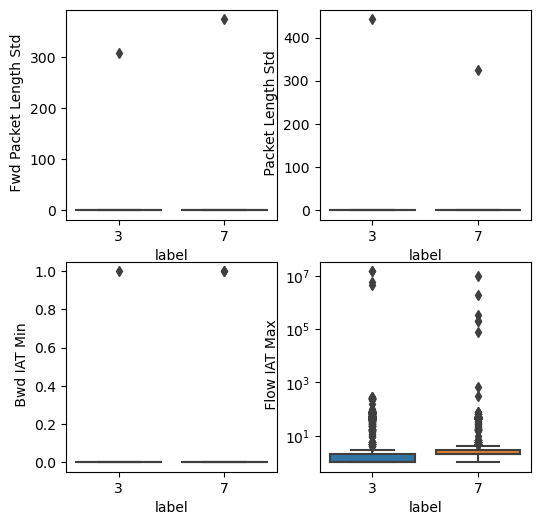

In [43]:
fig,ax = plt.subplots(2,2,figsize=(6,6))
sns.boxplot(data = df_37,y = ' Fwd Packet Length Std',x = 'label',ax=ax[0,0])
sns.boxplot(data = df_37,y = ' Packet Length Std',x = 'label',ax=ax[0,1])
sns.boxplot(data = df_37,y = ' Bwd IAT Min',x = 'label',ax=ax[1,0])
sns.boxplot(data = df_37,y = ' Flow IAT Max',x = 'label',ax=ax[1,1])
ax[1, 1].set_yscale('log')